**Проект: Статистический анализ данных**

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Для проведения анализа потребуется выполнить следующие основные задачи:
- выполнить предобработку данных
- выполнить исследовательский анализ данных (описать и визуализировать общую информацию о пользователях и поездках)
- объединить данные о пользователях, поездках и подписках
- подсчитать выручку
- проверить гипотезы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

##### Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы

В users_go содержиться инофрмация о пользователях, в rides_go о поездках, в subscriptions_go о подписках.

In [2]:
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

#####  Выведим первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме

In [3]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Пользовательские данные (users_go) cодержит 1565 записей и 5 столбцов. Вся информация полная, отсутствуют пропуски, как и для других датафреймов. Данные о поездках (rides_go) cодержит 18068 записей и 4 столбца. Данные о подписках (subscriptions_go) содержит только 2 записи (для типов подписок free и ultra) и 4 столбца.**

#### Шаг 2. Предобработка данных

##### Приведем столбец date к типу даты pandas.

In [9]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d %H:%M')

##### Создадим новый столбец с номером месяца на основе столбца date.

In [10]:
rides_go['month number'] = rides_go['date'].dt.month

##### Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработуем их, если такие значения присутствуют.

In [11]:
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
rides_go.isna().sum()

user_id         0
distance        0
duration        0
date            0
month number    0
dtype: int64

In [13]:
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков во всех датафреймах не обнаружено. Проверим на дубликаты.

In [14]:
duplicates_users_go_sum = users_go.duplicated().sum()
duplicates_users_go_sum

31

In [15]:
duplicates_rides_go_sum = rides_go.duplicated().sum()
duplicates_rides_go_sum

0

In [16]:
duplicates_subscriptions_go_sum = subscriptions_go.duplicated().sum()
duplicates_subscriptions_go_sum

0

Дубликаты были обнаружены только в users_go, удалим их. Также проверим: есть ли неявные дубликаты в users_go.

In [17]:
users_go_filtred = users_go.drop_duplicates()

In [18]:
duplicates_users_go_sum = users_go_filtred.duplicated().sum()
duplicates_users_go_sum 

0

In [19]:
users_go_filtred_1 = users_go_filtred.copy()
users_go_filtred_1 ['name'] = users_go_filtred ['name'].str.strip().str.lower()
users_go_filtred_1 ['city'] = users_go_filtred ['city'].str.strip().str.lower()
users_go_filtred_1 ['subscription_type'] = users_go_filtred ['subscription_type'].str.strip().str.lower()
duplicates_users_1 = users_go_filtred_1.duplicated()
print("Неявные дубликаты в users_go:", duplicates_users_1.sum()) 

Неявные дубликаты в users_go: 0


#### Шаг 3. Исследовательский анализ данных

**Опишим и визуализируем общую информацию о пользователях и поездках:**

##### Частота встречаемости городов

In [20]:
users_go_filtred['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

In [21]:
city_counts = users_go_filtred['city'].value_counts()
city_counts

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

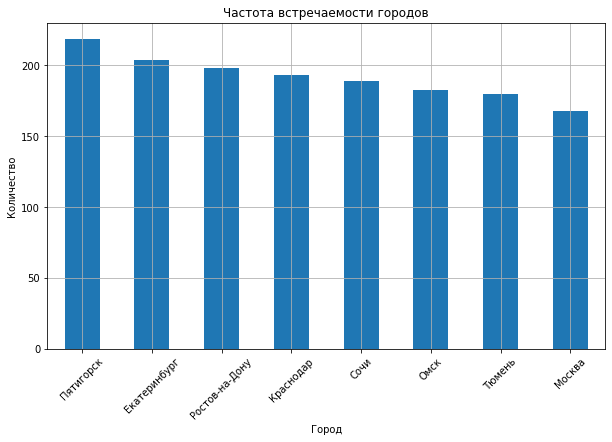

In [22]:
users_go_plot_city = city_counts.plot(title='Частота встречаемости городов', kind='bar', grid=True, figsize=(10, 6))
users_go_plot_city.set_xlabel('Город')
users_go_plot_city.set_ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

**Чаще всего встречается Пятигорс - 219 раз, меньше всего Москва - 168.**

##### Cоотношение пользователей с подпиской и без подписки

In [23]:
users_go_filtred_ultra = users_go_filtred[users_go_filtred['subscription_type'] == 'ultra']
users_go_filtred_free = users_go_filtred[users_go_filtred['subscription_type'] == 'free']

print('Пользователи с подпиской:', users_go_filtred_ultra.value_counts().sum())
print('Пользователи без подпиской:',users_go_filtred_free.value_counts().sum())

Пользователи с подпиской: 699
Пользователи без подпиской: 835


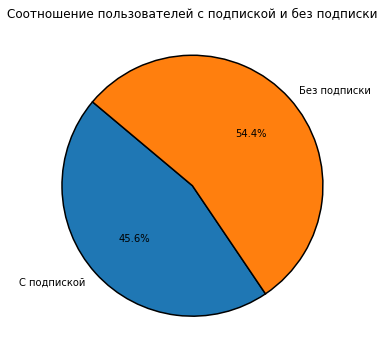

In [24]:
subscription_counts = [users_go_filtred_ultra['subscription_type'].count(), users_go_filtred_free['subscription_type'].count()]
labels = ['С подпиской', 'Без подписки']

plt.figure(figsize=(10, 6))
plt.pie(subscription_counts, labels=labels, autopct='%1.1f%%', startangle=140,  
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

**Почти 46% людей использует подписку, а остальные нет.**

##### Возраст пользователей

In [25]:
users_go_filtred['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [26]:
users_go_filtred['age'].value_counts()

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

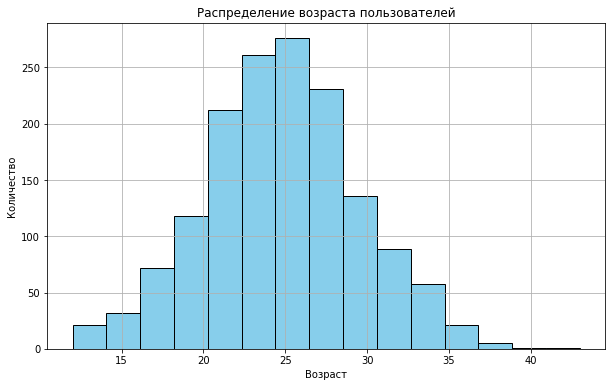

In [27]:
users_go_plot_age = users_go_filtred['age'].plot(title='Распределение возраста пользователей', kind='hist', bins=15, grid=True, 
                                             figsize=(10,6), color='skyblue', edgecolor='black')
users_go_plot_age.set_xlabel('Возраст')
users_go_plot_age.set_ylabel('Количество')
plt.show()

**Средний возраст пользователей 25 лет. Стандартное отклонение составляет 4.6 лет. График представляет собой нормальное распределение.**

##### Расстояние, которое пользователь преодолел за одну поездку

In [28]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

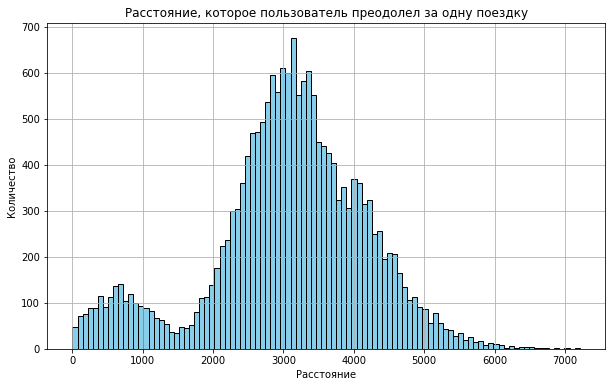

In [29]:
rides_go_plot_distance = rides_go['distance'].plot(title='Расстояние, которое пользователь преодолел за одну поездку', kind='hist', 
                                                   bins=100, grid=True, figsize=(10,6), color='skyblue', edgecolor='black')
rides_go_plot_distance.set_xlabel('Расстояние')
rides_go_plot_distance.set_ylabel('Количество')
plt.show()

**Гистограмма имеет вид колоколообразной формы, напоминающий нормальное распределение. Это указывает на то, что большинство пользователей преодолевают определенное среднее расстояние за поездку, есть симметричное уменьшение количества поездок по мере увеличения или уменьшения расстояния от этого среднего значения. Однако есть пик слева, который указывает на группу коротких поездок, совершающихся значительно чаще, чем можно было бы ожидать в рамках нормального распределения.**

##### Продолжительность поездок

In [30]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

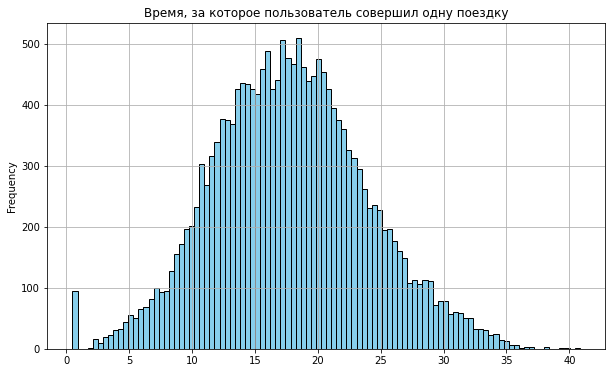

In [31]:
rides_go_plot_duration = rides_go['duration'].plot(title='Время, за которое пользователь совершил одну поездку', kind='hist', 
                                                   bins=100, grid=True, figsize=(10,6), color='skyblue', edgecolor='black')
rides_go_plot_distance.set_xlabel('Время')
rides_go_plot_distance.set_ylabel('Количество')
plt.show()

**Форма графика соответсвует нормальному распределению, но есть аномально большое количество очень коротких поездок. Убрать их не получится, так как они вполне возможны. Среднее время поездок составляет 17 минут.**

#### Шаг 4. Объединение данных

##### Объединим данные о пользователях, поездках и подписках в один датафрейм

In [32]:
users_and_rides = users_go_filtred.merge(rides_go, on='user_id')
users_and_rides.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month number
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [33]:
users_rides_subscriptions_go = users_and_rides.merge(subscriptions_go, on='subscription_type')
print("Размерность:", users_rides_subscriptions_go.shape)
users_rides_subscriptions_go.head(20)

Размерность: (18068, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


##### Создадим  два датафрейма c данными о пользователях без подписки и с данными о пользователях с подпиской

In [34]:
subscriptions_free = users_rides_subscriptions_go[users_rides_subscriptions_go['subscription_type'] == 'free']
print("Размерность:", subscriptions_free.shape)
subscriptions_free.head()

Размерность: (11568, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month number,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [35]:
subscriptions_ultra = users_rides_subscriptions_go[users_rides_subscriptions_go['subscription_type'] == 'ultra']
print("Размерность:", subscriptions_ultra.shape)
subscriptions_ultra.head()

Размерность: (6500, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

In [36]:
subscriptions_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [37]:
subscriptions_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

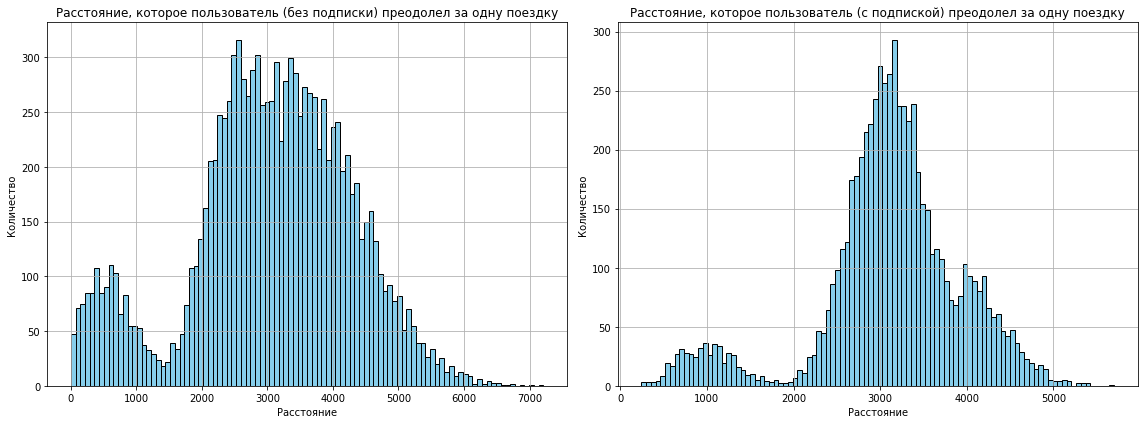

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6)) 

subscriptions_free_plot = subscriptions_free['distance'].plot(
    title='Расстояние, которое пользователь (без подписки) преодолел за одну поездку',
    kind='hist', 
    bins=100, 
    grid=True, 
    ax=axes[0], 
    color='skyblue', 
    edgecolor='black'
)
axes[0].set_xlabel('Расстояние')
axes[0].set_ylabel('Количество')

subscriptions_ultra_plot = subscriptions_ultra['distance'].plot(
    title='Расстояние, которое пользователь (с подпиской) преодолел за одну поездку',
    kind='hist', 
    bins=100, 
    grid=True, 
    ax=axes[1],  
    color='skyblue', 
    edgecolor='black'
)
axes[1].set_xlabel('Расстояние')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

****

**Для пользователей без подписки распределение расстояний более равномерное и имеет широкий диапазон. Видна высокая частота коротких поездок (в диапазоне до 1000 метров), что, возможно, указывает на пользователей, которые используют сервис для краткосрочных перемещений. После пика около 3000 метров частота постепенно уменьшается, но диапазон поездок довольно большой, вплоть до 7000 метров.**

**Для пользователей с подпиской пик в распределении также находится около 3000 метров, но график более "симметричен" и центрирован. У подписчиков меньше поездок на экстремально короткие и длинные расстояния, чем у пользователей без подписки.**

**Таким образом, можно сделать вывод, что пользователи без подписки чаще совершают короткие и очень длинные поездки, что может говорить о том, что они используют сервис нерегулярно или для краткосрочных нужд. Подписчики же, наоборот, более склонны к поездкам на средние дистанции, оптимизируя использование подписки.**

In [39]:
subscriptions_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [40]:
subscriptions_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

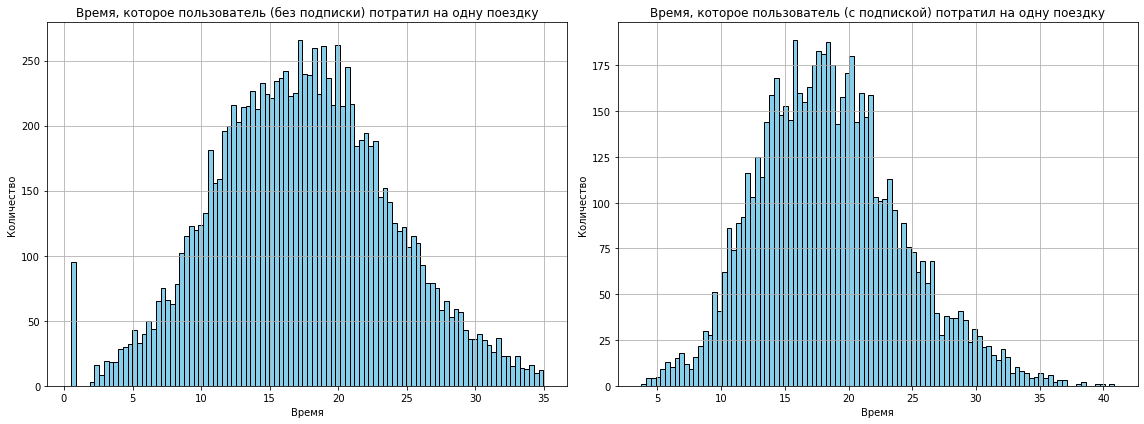

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6)) 

subscriptions_free_plot = subscriptions_free['duration'].plot(
    title='Время, которое пользователь (без подписки) потратил на одну поездку',
    kind='hist', 
    bins=100, 
    grid=True, 
    ax=axes[0], 
    color='skyblue', 
    edgecolor='black'
)
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Количество')

subscriptions_ultra_plot = subscriptions_ultra['duration'].plot(
    title='Время, которое пользователь (с подпиской) потратил на одну поездку',
    kind='hist', 
    bins=100, 
    grid=True, 
    ax=axes[1],  
    color='skyblue', 
    edgecolor='black'
)
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

**Время, затраченное на одну поездку, имеет широкое распределение с пиком примерно около 17 минут для пользователей без подписки.Есть  значительный выброс на малых значениях времени (около 1 минуты), что может говорить о коротких пробных поездках или небольших перемещениях.**

**У подписчиков  пик распределения около 18 минут, но распределение чуть уже и более симметрично. Нет выбросов на короткие поездки. Это может указывать на то, что пользователи с подпиской более последовательно используют сервис для поездок средней длительности.**

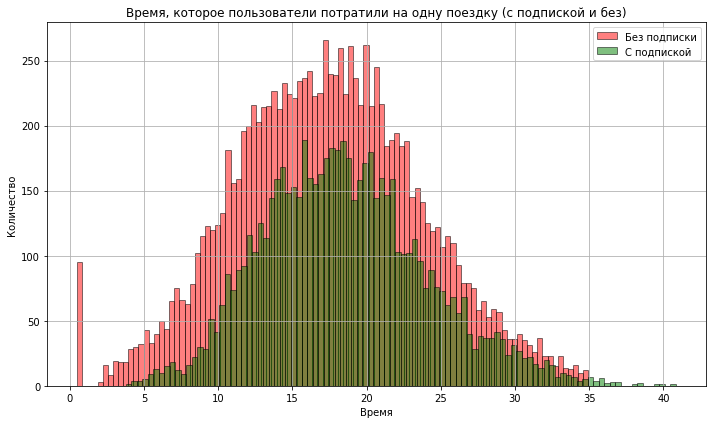

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

subscriptions_free_plot = subscriptions_free['duration'].plot(
    kind='hist', 
    bins=100, 
    alpha=0.5,
    grid=True, 
    ax=ax, 
    color='red', 
    edgecolor='black',
    label='Без подписки'
)

subscriptions_ultra_plot = subscriptions_ultra['duration'].plot(
    kind='hist', 
    bins=100,
    alpha=0.5,
    grid=True, 
    ax=ax,  
    color='green', 
    edgecolor='black',
    label='С подпиской'
)

ax.set_title('Время, которое пользователи потратили на одну поездку (с подпиской и без)')
ax.set_xlabel('Время')
ax.set_ylabel('Количество')
ax.legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>Построил графики с наложением. 🙂
</div>

#### Шаг 5. Подсчёт выручки

##### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными.  Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [43]:
users_rides_subscriptions_go['duration'] = np.ceil(users_rides_subscriptions_go['duration'])
monthly_stats = users_rides_subscriptions_go.groupby(['user_id', 'month number']).agg(
    total_distance=('distance', 'sum'),
    total_trips=('distance', 'count'),
    total_duration=('duration', 'sum'),
    subscription_type=('subscription_type', 'first')
).reset_index()

monthly_stats.head()

,user_id,month number,total_distance,total_trips,total_duration,subscription_type
0,1,1,7027.511294,2,42.0,ultra
1,1,4,754.159807,1,7.0,ultra
2,1,8,6723.470560,2,46.0,ultra
3,1,10,5809.911100,2,32.0,ultra
4,1,11,7003.499363,3,56.0,ultra


#####  Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [44]:
def calculate_revenue(row):
    if row['subscription_type'] == 'ultra':
        return 199 + (6 * row['total_duration'])
    else:
        return 50 * row['total_trips'] + (8 * row['total_duration'])
    
monthly_stats['total_revenue'] = monthly_stats.apply(calculate_revenue, axis=1)
monthly_stats.head()

,user_id,month number,total_distance,total_trips,total_duration,subscription_type,total_revenue
0,1,1,7027.511294,2,42.0,ultra,451.0
1,1,4,754.159807,1,7.0,ultra,241.0
2,1,8,6723.470560,2,46.0,ultra,475.0
3,1,10,5809.911100,2,32.0,ultra,391.0
4,1,11,7003.499363,3,56.0,ultra,535.0


#### Шаг 6. Проверка гипотез

##### Узнаем, тратят ли пользователи с подпиской больше времени на поездки

Нулевая гипотеза (H0): Средняя продолжительность поездок пользователей с подпиской равна средней продолжительности поездок пользователей без подписки.

Альтернативная гипотеза (H1): Средняя продолжительность поездок пользователей с подпиской больше средней продолжительности поездок пользователей без подписки.

In [45]:
mean_duration_subscribers = subscriptions_ultra['duration'].mean()
mean_duration_non_subscribers = subscriptions_free['duration'].mean()

print(mean_duration_subscribers)
print(mean_duration_non_subscribers)

alpha = 0.05

results = st.ttest_ind(subscriptions_ultra['duration'], subscriptions_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

18.54198516280583
17.39090929866399
p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Результаты указывают на то, что средняя продолжительность поездок пользователей с подпиской больше, чем у пользователей без подписки.**

##### Проверим: не прревышает ли среднее расстояние  3130 метров для полльзователей с подпиской

Нулевая гипотеза (H0): Среднее расстояние поездок пользователей с подпиской не превышает 3130 метров (μ ≤ 3130).


Альтернативная гипотеза (H1): Среднее расстояние поездок пользователей с подпиской превышает 3130 метров (μ > 3130).

In [46]:
alpha = 0.05
interested_value = 3130

results = st.ttest_1samp(subscriptions_ultra['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Среднее расстояние поездок пользователей с подпиской, вероятно, не превышает 3130 метров. Иными словами, нет статистических оснований считать, что пользователи с подпиской проезжают в среднем больше 3130 метров за одну поездку. Это может означать, что текущий уровень износа, обусловленный расстоянием поездок подписчиков, остается в приемлемых пределах.**

##### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Нулевая гипотеза (H0): Помесячная выручка от пользователей с подпиской не превышает выручку от пользователей без подписки.


Альтернативная гипотеза (H1): Помесячная выручка от пользователей с подпиской превышает выручку от пользователей без подписки.

In [47]:
alpha = 0.05

revenue_ultra = monthly_stats[monthly_stats['subscription_type'] == 'ultra']['total_revenue']
revenue_free = monthly_stats[monthly_stats['subscription_type'] == 'free']['total_revenue']

results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Результаты указывают на то, что помесячная выручка от пользователей с подпиской статистически выше, чем у пользователей без подписки. Это может означать, что пользователи с подпиской более активны или совершают более дорогие поездки.**

##### Гипотеза о снижении обращений в техподдрежку

Для проверки гипотезы нужно выполнить тест на зависимость между двумя связанными выборками.

Нулевая гипотеза (H0): Среднее количестов обрашений в техподдержку не изменилось.

Альтернативная гипотеза (H1): Среднее количестов обрашений в техподдержку изменилось.

Выборки в этом случае будут зависимыми, иначе — парными. Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод `scipy.stats.ttest_rel()`. Ему достаточно передать всего два параметра: наборы данных до и после. 

#### Шаг 7. Распределения

К сожалению, никак не успеваю выполнить необязательное задание

#### Шаг 8. Общий вывод

В ходе проведенного анализа было выявлено, что наиболее часто встречается город Пятигорск, а наименее — Москва. Всего 46% пользователей используют подписку. Средний возраст пользователей составляет 25 лет. Обычно они проезжают около 3 км за одну поездку.

Пользователи без подписки чаще совершают короткие и очень длинные поездки, что может говорить о том, что они используют сервис нерегулярно или для краткосрочных нужд. Подписчики же, наоборот, более склонны к поездкам на средние дистанции, оптимизируя использование подписки.

Время, затраченное на одну поездку, имеет широкое распределение с пиком примерно около 17 минут для пользователей без подписки и 18 минут для пользователей с подпиской.

Был создан датафрейм, содержащий ежемесячную выручку, которую принес каждый пользователь.

Было проверено несколько гипотез:

- Тратят ли пользователи с подпиской больше времени на поездки? (Результаты указывают на то, что средняя продолжительность поездок пользователей с подпиской больше, чем у пользователей без подписки)
- Не превышает ли среднее расстояние 3130 метров для пользователей с подпиской? (На основании анализа нет статистических оснований считать, что среднее расстояние поездок подписчиков превышает 3130 метров. Иными словами, пользователи с подпиской, вероятно, проезжают в среднем не более 3130 метров за одну поездку, что может свидетельствовать о допустимом уровне износа самокатов при текущих условиях)
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? (Результаты указывают на то, что помесячная выручка от пользователей с подпиской статистически выше, чем у пользователей без подписки)
- Снизится ли количество обращений в техподдержку? (Вывод по этой гипотезе невозможен, так как у нас нет файла с информацией об обращениях до и после внесения изменений, но предложена основная идея её проверки)